# Optimized Data Set Dimensionality Study

In [1]:
#imports and loads

import seaborn as sns
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


coord = np.load('airfoils_opt.npy')
aoa = np.load('aoas_opt.npy')
inputs = np.load('inp_paras.npy')

cor = np.arange(0,384,1)
df = pd.DataFrame(coord.reshape(1042,384), columns = [cor])


#Scaling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaleddf = pd.DataFrame(scaled, columns = [cor])
#print(scaleddf)

#Use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

num = 5
comp = 4
test_size = 0.2
train_size = (1-test_size)*1042
ts = 1042 - train_size
X_train = np.zeros((num, int(test_size),384), dtype=float)
X_test = np.zeros((num, int(ts), 384), dtype=float)

Using cuda device


In [2]:
class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 384),
            nn.ReLU(True),
            nn.Linear(384, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 384),
            nn.ReLU(True),
            nn.Linear(384, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [3]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        error = nn.MSELoss()
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.05*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [4]:

num = 25 #number of training-testing splits
dim = 20 #latent space size
MSE_TRAIN = np.zeros((dim, num), dtype=float)
MSE_TEST = np.zeros((dim, num), dtype=float)
RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
output = np.zeros((dim, num, int(train_size),384), dtype=float)
output_y = np.zeros((dim, num, math.ceil(ts),384), dtype=float)


def complete_train_test(n_epochs, scaled, num):
    for i in range(1,dim+1):
        encoder = Autoencoder(in_shape=384, enc_shape=i).double().to(device)
        error = nn.MSELoss()
        learning_rate = 0.0001
        optimizer = optim.Adam(encoder.parameters(),lr=learning_rate, weight_decay=0)
    
        for j in range(num):
            x, y = train_test_split(scaled, test_size=test_size, shuffle=True)
            train(encoder, error, optimizer, n_epochs, torch.from_numpy(x).to(device))
        
            output[i-1][j] = encoder(torch.from_numpy(x).to(device)).detach().cpu().numpy()
            output_y[i-1][j] = encoder(torch.from_numpy(y).to(device)).detach().cpu().numpy()
            
            MSE_TRAIN[i-1][j] = mean_squared_error(x, output[i-1][j])
            MSE_TEST[i-1][j] = mean_squared_error(y, output_y[i-1][j])
            
            RE[i-1][j] = ((output_y[i-1][j] - y)**2).mean(axis=1)
            print(f'\nLatent Space Size: {i}   \nIteration: {j}')
    print(f'\nMSE TEST: {MSE_TEST} \nMSE TRAIN: {MSE_TRAIN}\n\n')

In [5]:
%%time
complete_train_test(1000, scaled, num)
#Assumes the learning rate is constant

epoch 50 	 Loss: 0.09726
epoch 100 	 Loss: 0.04856
epoch 150 	 Loss: 0.03673
epoch 200 	 Loss: 0.0278
epoch 250 	 Loss: 0.0208
epoch 300 	 Loss: 0.01657
epoch 350 	 Loss: 0.01385
epoch 400 	 Loss: 0.01194
epoch 450 	 Loss: 0.01048
epoch 500 	 Loss: 0.009294
epoch 550 	 Loss: 0.008341
epoch 600 	 Loss: 0.007572
epoch 650 	 Loss: 0.006962
epoch 700 	 Loss: 0.006455
epoch 750 	 Loss: 0.006062
epoch 800 	 Loss: 0.005741
epoch 850 	 Loss: 0.005486
epoch 900 	 Loss: 0.005272
epoch 950 	 Loss: 0.005076
epoch 1000 	 Loss: 0.004938

Latent Space Size: 1   
Iteration: 0
epoch 50 	 Loss: 0.004585
epoch 100 	 Loss: 0.004457
epoch 150 	 Loss: 0.004347
epoch 200 	 Loss: 0.004238
epoch 250 	 Loss: 0.004124
epoch 300 	 Loss: 0.004018
epoch 350 	 Loss: 0.003955
epoch 400 	 Loss: 0.003825
epoch 450 	 Loss: 0.003695
epoch 500 	 Loss: 0.003583
epoch 550 	 Loss: 0.003505
epoch 600 	 Loss: 0.00344
epoch 650 	 Loss: 0.003282
epoch 700 	 Loss: 0.003212
epoch 750 	 Loss: 0.003109
epoch 800 	 Loss: 0.00302
epoc

epoch 150 	 Loss: 0.000709
epoch 200 	 Loss: 0.0007133
epoch 250 	 Loss: 0.0007086
epoch 300 	 Loss: 0.0007037
epoch 350 	 Loss: 0.0007012
epoch 400 	 Loss: 0.0007007
epoch 450 	 Loss: 0.0006978
epoch 500 	 Loss: 0.0006963
epoch 550 	 Loss: 0.000699
epoch 600 	 Loss: 0.0006959
epoch 650 	 Loss: 0.0006966
epoch 700 	 Loss: 0.0006936
epoch 750 	 Loss: 0.0006908
epoch 800 	 Loss: 0.0006877
epoch 850 	 Loss: 0.0006875
epoch 900 	 Loss: 0.0006902
epoch 950 	 Loss: 0.0006847
epoch 1000 	 Loss: 0.000684

Latent Space Size: 1   
Iteration: 14
epoch 50 	 Loss: 0.0008064
epoch 100 	 Loss: 0.0007865
epoch 150 	 Loss: 0.0007824
epoch 200 	 Loss: 0.0007803
epoch 250 	 Loss: 0.0007786
epoch 300 	 Loss: 0.0007785
epoch 350 	 Loss: 0.0007752
epoch 400 	 Loss: 0.0007728
epoch 450 	 Loss: 0.0007708
epoch 500 	 Loss: 0.0007982
epoch 550 	 Loss: 0.0007694
epoch 600 	 Loss: 0.0007686
epoch 650 	 Loss: 0.0007639
epoch 700 	 Loss: 0.0007635
epoch 750 	 Loss: 0.0007649
epoch 800 	 Loss: 0.0007598
epoch 850 	 

epoch 50 	 Loss: 0.000899
epoch 100 	 Loss: 0.0008867
epoch 150 	 Loss: 0.0008776
epoch 200 	 Loss: 0.0008702
epoch 250 	 Loss: 0.0008654
epoch 300 	 Loss: 0.0008511
epoch 350 	 Loss: 0.0008479
epoch 400 	 Loss: 0.0008424
epoch 450 	 Loss: 0.0008317
epoch 500 	 Loss: 0.0008187
epoch 550 	 Loss: 0.0008119
epoch 600 	 Loss: 0.0008034
epoch 650 	 Loss: 0.0007983
epoch 700 	 Loss: 0.0007896
epoch 750 	 Loss: 0.0007795
epoch 800 	 Loss: 0.0007739
epoch 850 	 Loss: 0.0007638
epoch 900 	 Loss: 0.0007591
epoch 950 	 Loss: 0.0007515
epoch 1000 	 Loss: 0.0007605

Latent Space Size: 2   
Iteration: 3
epoch 50 	 Loss: 0.0007908
epoch 100 	 Loss: 0.0007872
epoch 150 	 Loss: 0.0007687
epoch 200 	 Loss: 0.0007572
epoch 250 	 Loss: 0.0007468
epoch 300 	 Loss: 0.0007366
epoch 350 	 Loss: 0.0007279
epoch 400 	 Loss: 0.0007191
epoch 450 	 Loss: 0.0007088
epoch 500 	 Loss: 0.0007025
epoch 550 	 Loss: 0.0006908
epoch 600 	 Loss: 0.0006819
epoch 650 	 Loss: 0.0006734
epoch 700 	 Loss: 0.0006706
epoch 750 	 

epoch 850 	 Loss: 0.0002024
epoch 900 	 Loss: 0.0002003
epoch 950 	 Loss: 0.0002058
epoch 1000 	 Loss: 0.0001959

Latent Space Size: 2   
Iteration: 16
epoch 50 	 Loss: 0.0002109
epoch 100 	 Loss: 0.0002097
epoch 150 	 Loss: 0.0002102
epoch 200 	 Loss: 0.0002101
epoch 250 	 Loss: 0.0002095
epoch 300 	 Loss: 0.000207
epoch 350 	 Loss: 0.0002059
epoch 400 	 Loss: 0.000214
epoch 450 	 Loss: 0.0002065
epoch 500 	 Loss: 0.0002087
epoch 550 	 Loss: 0.0002043
epoch 600 	 Loss: 0.0002061
epoch 650 	 Loss: 0.0002062
epoch 700 	 Loss: 0.0002033
epoch 750 	 Loss: 0.0002037
epoch 800 	 Loss: 0.0002026
epoch 850 	 Loss: 0.0002019
epoch 900 	 Loss: 0.0002015
epoch 950 	 Loss: 0.0002032
epoch 1000 	 Loss: 0.0002024

Latent Space Size: 2   
Iteration: 17
epoch 50 	 Loss: 0.0002149
epoch 100 	 Loss: 0.0002119
epoch 150 	 Loss: 0.0002109
epoch 200 	 Loss: 0.0002104
epoch 250 	 Loss: 0.0002104
epoch 300 	 Loss: 0.0002133
epoch 350 	 Loss: 0.0002091
epoch 400 	 Loss: 0.0002091
epoch 450 	 Loss: 0.000209
e

epoch 650 	 Loss: 0.0002539
epoch 700 	 Loss: 0.0002533
epoch 750 	 Loss: 0.0002502
epoch 800 	 Loss: 0.000247
epoch 850 	 Loss: 0.0002603
epoch 900 	 Loss: 0.0002423
epoch 950 	 Loss: 0.000243
epoch 1000 	 Loss: 0.0002407

Latent Space Size: 3   
Iteration: 5
epoch 50 	 Loss: 0.0002145
epoch 100 	 Loss: 0.0002108
epoch 150 	 Loss: 0.0002081
epoch 200 	 Loss: 0.0002055
epoch 250 	 Loss: 0.0002035
epoch 300 	 Loss: 0.0002014
epoch 350 	 Loss: 0.0001993
epoch 400 	 Loss: 0.0001972
epoch 450 	 Loss: 0.0001968
epoch 500 	 Loss: 0.000196
epoch 550 	 Loss: 0.0001985
epoch 600 	 Loss: 0.0001918
epoch 650 	 Loss: 0.0001891
epoch 700 	 Loss: 0.000188
epoch 750 	 Loss: 0.0001906
epoch 800 	 Loss: 0.0001889
epoch 850 	 Loss: 0.000184
epoch 900 	 Loss: 0.0001817
epoch 950 	 Loss: 0.0001802
epoch 1000 	 Loss: 0.0001788

Latent Space Size: 3   
Iteration: 6
epoch 50 	 Loss: 0.0002129
epoch 100 	 Loss: 0.0002088
epoch 150 	 Loss: 0.0002083
epoch 200 	 Loss: 0.0002066
epoch 250 	 Loss: 0.0002024
epoch

epoch 400 	 Loss: 8.628e-05
epoch 450 	 Loss: 8.747e-05
epoch 500 	 Loss: 8.294e-05
epoch 550 	 Loss: 8.38e-05
epoch 600 	 Loss: 8.311e-05
epoch 650 	 Loss: 8.259e-05
epoch 700 	 Loss: 8.202e-05
epoch 750 	 Loss: 8.164e-05
epoch 800 	 Loss: 8.141e-05
epoch 850 	 Loss: 8.163e-05
epoch 900 	 Loss: 8.328e-05
epoch 950 	 Loss: 8.574e-05
epoch 1000 	 Loss: 8.11e-05

Latent Space Size: 3   
Iteration: 19
epoch 50 	 Loss: 8.201e-05
epoch 100 	 Loss: 8.03e-05
epoch 150 	 Loss: 8.006e-05
epoch 200 	 Loss: 8.275e-05
epoch 250 	 Loss: 7.917e-05
epoch 300 	 Loss: 7.895e-05
epoch 350 	 Loss: 8.138e-05
epoch 400 	 Loss: 8.194e-05
epoch 450 	 Loss: 7.801e-05
epoch 500 	 Loss: 8.053e-05
epoch 550 	 Loss: 7.751e-05
epoch 600 	 Loss: 7.885e-05
epoch 650 	 Loss: 8.147e-05
epoch 700 	 Loss: 7.744e-05
epoch 750 	 Loss: 7.845e-05
epoch 800 	 Loss: 7.837e-05
epoch 850 	 Loss: 8.607e-05
epoch 900 	 Loss: 7.623e-05
epoch 950 	 Loss: 7.632e-05
epoch 1000 	 Loss: 7.676e-05

Latent Space Size: 3   
Iteration: 20


epoch 150 	 Loss: 0.0001096
epoch 200 	 Loss: 0.0001096
epoch 250 	 Loss: 0.0001061
epoch 300 	 Loss: 0.0001042
epoch 350 	 Loss: 0.000106
epoch 400 	 Loss: 0.0001064
epoch 450 	 Loss: 0.0001108
epoch 500 	 Loss: 0.0001001
epoch 550 	 Loss: 9.932e-05
epoch 600 	 Loss: 0.0001057
epoch 650 	 Loss: 9.893e-05
epoch 700 	 Loss: 9.862e-05
epoch 750 	 Loss: 9.723e-05
epoch 800 	 Loss: 0.0001029
epoch 850 	 Loss: 0.0001027
epoch 900 	 Loss: 9.55e-05
epoch 950 	 Loss: 0.0001068
epoch 1000 	 Loss: 9.349e-05

Latent Space Size: 4   
Iteration: 8
epoch 50 	 Loss: 0.0001045
epoch 100 	 Loss: 9.999e-05
epoch 150 	 Loss: 9.838e-05
epoch 200 	 Loss: 9.728e-05
epoch 250 	 Loss: 9.821e-05
epoch 300 	 Loss: 9.987e-05
epoch 350 	 Loss: 9.811e-05
epoch 400 	 Loss: 9.867e-05
epoch 450 	 Loss: 9.499e-05
epoch 500 	 Loss: 9.521e-05
epoch 550 	 Loss: 9.382e-05
epoch 600 	 Loss: 9.253e-05
epoch 650 	 Loss: 9.163e-05
epoch 700 	 Loss: 9.175e-05
epoch 750 	 Loss: 9.171e-05
epoch 800 	 Loss: 8.996e-05
epoch 850 	 

epoch 950 	 Loss: 4.231e-05
epoch 1000 	 Loss: 4.15e-05

Latent Space Size: 4   
Iteration: 21
epoch 50 	 Loss: 5.26e-05
epoch 100 	 Loss: 4.769e-05
epoch 150 	 Loss: 4.669e-05
epoch 200 	 Loss: 4.611e-05
epoch 250 	 Loss: 4.572e-05
epoch 300 	 Loss: 4.541e-05
epoch 350 	 Loss: 4.516e-05
epoch 400 	 Loss: 4.494e-05
epoch 450 	 Loss: 4.474e-05
epoch 500 	 Loss: 4.473e-05
epoch 550 	 Loss: 4.449e-05
epoch 600 	 Loss: 4.453e-05
epoch 650 	 Loss: 4.977e-05
epoch 700 	 Loss: 4.397e-05
epoch 750 	 Loss: 4.442e-05
epoch 800 	 Loss: 4.37e-05
epoch 850 	 Loss: 4.489e-05
epoch 900 	 Loss: 4.354e-05
epoch 950 	 Loss: 4.424e-05
epoch 1000 	 Loss: 4.428e-05

Latent Space Size: 4   
Iteration: 22
epoch 50 	 Loss: 4.902e-05
epoch 100 	 Loss: 4.967e-05
epoch 150 	 Loss: 4.822e-05
epoch 200 	 Loss: 4.891e-05
epoch 250 	 Loss: 5.16e-05
epoch 300 	 Loss: 4.939e-05
epoch 350 	 Loss: 4.76e-05
epoch 400 	 Loss: 4.727e-05
epoch 450 	 Loss: 4.754e-05
epoch 500 	 Loss: 4.69e-05
epoch 550 	 Loss: 4.698e-05
epoc

epoch 700 	 Loss: 5.786e-05
epoch 750 	 Loss: 5.559e-05
epoch 800 	 Loss: 5.634e-05
epoch 850 	 Loss: 5.386e-05
epoch 900 	 Loss: 5.35e-05
epoch 950 	 Loss: 5.335e-05
epoch 1000 	 Loss: 5.665e-05

Latent Space Size: 5   
Iteration: 10
epoch 50 	 Loss: 6.183e-05
epoch 100 	 Loss: 5.503e-05
epoch 150 	 Loss: 5.706e-05
epoch 200 	 Loss: 5.626e-05
epoch 250 	 Loss: 5.22e-05
epoch 300 	 Loss: 5.408e-05
epoch 350 	 Loss: 5.703e-05
epoch 400 	 Loss: 5.245e-05
epoch 450 	 Loss: 5.07e-05
epoch 500 	 Loss: 4.943e-05
epoch 550 	 Loss: 4.892e-05
epoch 600 	 Loss: 5.237e-05
epoch 650 	 Loss: 5.091e-05
epoch 700 	 Loss: 5.393e-05
epoch 750 	 Loss: 4.866e-05
epoch 800 	 Loss: 5.652e-05
epoch 850 	 Loss: 4.755e-05
epoch 900 	 Loss: 4.632e-05
epoch 950 	 Loss: 4.651e-05
epoch 1000 	 Loss: 4.658e-05

Latent Space Size: 5   
Iteration: 11
epoch 50 	 Loss: 4.752e-05
epoch 100 	 Loss: 4.64e-05
epoch 150 	 Loss: 4.583e-05
epoch 200 	 Loss: 4.532e-05
epoch 250 	 Loss: 4.486e-05
epoch 300 	 Loss: 4.465e-05
ep

epoch 400 	 Loss: 1.914e-05
epoch 450 	 Loss: 1.881e-05
epoch 500 	 Loss: 1.876e-05
epoch 550 	 Loss: 1.939e-05
epoch 600 	 Loss: 1.875e-05
epoch 650 	 Loss: 1.939e-05
epoch 700 	 Loss: 1.965e-05
epoch 750 	 Loss: 1.863e-05
epoch 800 	 Loss: 1.908e-05
epoch 850 	 Loss: 1.871e-05
epoch 900 	 Loss: 1.879e-05
epoch 950 	 Loss: 1.859e-05
epoch 1000 	 Loss: 2.284e-05

Latent Space Size: 5   
Iteration: 24
epoch 50 	 Loss: 0.09785
epoch 100 	 Loss: 0.03057
epoch 150 	 Loss: 0.01558
epoch 200 	 Loss: 0.008343
epoch 250 	 Loss: 0.00479
epoch 300 	 Loss: 0.003139
epoch 350 	 Loss: 0.002343
epoch 400 	 Loss: 0.001909
epoch 450 	 Loss: 0.001641
epoch 500 	 Loss: 0.00146
epoch 550 	 Loss: 0.00133
epoch 600 	 Loss: 0.001234
epoch 650 	 Loss: 0.00116
epoch 700 	 Loss: 0.001103
epoch 750 	 Loss: 0.001057
epoch 800 	 Loss: 0.001019
epoch 850 	 Loss: 0.0009854
epoch 900 	 Loss: 0.000955
epoch 950 	 Loss: 0.000921
epoch 1000 	 Loss: 0.000895

Latent Space Size: 6   
Iteration: 0
epoch 50 	 Loss: 0.00091

epoch 200 	 Loss: 2.385e-05
epoch 250 	 Loss: 2.361e-05
epoch 300 	 Loss: 2.501e-05
epoch 350 	 Loss: 2.386e-05
epoch 400 	 Loss: 2.307e-05
epoch 450 	 Loss: 2.418e-05
epoch 500 	 Loss: 2.27e-05
epoch 550 	 Loss: 2.257e-05
epoch 600 	 Loss: 2.84e-05
epoch 650 	 Loss: 2.234e-05
epoch 700 	 Loss: 2.231e-05
epoch 750 	 Loss: 2.222e-05
epoch 800 	 Loss: 2.269e-05
epoch 850 	 Loss: 2.166e-05
epoch 900 	 Loss: 2.402e-05
epoch 950 	 Loss: 3.1e-05
epoch 1000 	 Loss: 2.129e-05

Latent Space Size: 6   
Iteration: 13
epoch 50 	 Loss: 2.936e-05
epoch 100 	 Loss: 2.702e-05
epoch 150 	 Loss: 2.651e-05
epoch 200 	 Loss: 2.617e-05
epoch 250 	 Loss: 2.589e-05
epoch 300 	 Loss: 2.566e-05
epoch 350 	 Loss: 2.545e-05
epoch 400 	 Loss: 2.525e-05
epoch 450 	 Loss: 2.507e-05
epoch 500 	 Loss: 2.642e-05
epoch 550 	 Loss: 2.475e-05
epoch 600 	 Loss: 2.501e-05
epoch 650 	 Loss: 2.46e-05
epoch 700 	 Loss: 2.43e-05
epoch 750 	 Loss: 2.466e-05
epoch 800 	 Loss: 2.483e-05
epoch 850 	 Loss: 2.926e-05
epoch 900 	 Los

epoch 50 	 Loss: 0.0003964
epoch 100 	 Loss: 0.0003803
epoch 150 	 Loss: 0.0003661
epoch 200 	 Loss: 0.0003527
epoch 250 	 Loss: 0.0003399
epoch 300 	 Loss: 0.0003275
epoch 350 	 Loss: 0.0003157
epoch 400 	 Loss: 0.0003044
epoch 450 	 Loss: 0.0002935
epoch 500 	 Loss: 0.0002831
epoch 550 	 Loss: 0.0002732
epoch 600 	 Loss: 0.0002636
epoch 650 	 Loss: 0.0002546
epoch 700 	 Loss: 0.0002457
epoch 750 	 Loss: 0.0002375
epoch 800 	 Loss: 0.0002296
epoch 850 	 Loss: 0.0002231
epoch 900 	 Loss: 0.0002145
epoch 950 	 Loss: 0.0002083
epoch 1000 	 Loss: 0.0002018

Latent Space Size: 7   
Iteration: 2
epoch 50 	 Loss: 0.0002112
epoch 100 	 Loss: 0.0002005
epoch 150 	 Loss: 0.0001921
epoch 200 	 Loss: 0.0001844
epoch 250 	 Loss: 0.0001774
epoch 300 	 Loss: 0.0001709
epoch 350 	 Loss: 0.0001648
epoch 400 	 Loss: 0.0001592
epoch 450 	 Loss: 0.0001539
epoch 500 	 Loss: 0.000149
epoch 550 	 Loss: 0.0001445
epoch 600 	 Loss: 0.0001402
epoch 650 	 Loss: 0.0001373
epoch 700 	 Loss: 0.0001324
epoch 750 	 

epoch 850 	 Loss: 1.536e-05
epoch 900 	 Loss: 1.555e-05
epoch 950 	 Loss: 1.671e-05
epoch 1000 	 Loss: 1.587e-05

Latent Space Size: 7   
Iteration: 15
epoch 50 	 Loss: 1.769e-05
epoch 100 	 Loss: 1.641e-05
epoch 150 	 Loss: 1.616e-05
epoch 200 	 Loss: 1.599e-05
epoch 250 	 Loss: 1.585e-05
epoch 300 	 Loss: 1.573e-05
epoch 350 	 Loss: 1.562e-05
epoch 400 	 Loss: 1.552e-05
epoch 450 	 Loss: 1.543e-05
epoch 500 	 Loss: 1.567e-05
epoch 550 	 Loss: 1.575e-05
epoch 600 	 Loss: 1.588e-05
epoch 650 	 Loss: 1.523e-05
epoch 700 	 Loss: 1.532e-05
epoch 750 	 Loss: 1.504e-05
epoch 800 	 Loss: 1.58e-05
epoch 850 	 Loss: 1.487e-05
epoch 900 	 Loss: 1.49e-05
epoch 950 	 Loss: 1.508e-05
epoch 1000 	 Loss: 1.485e-05

Latent Space Size: 7   
Iteration: 16
epoch 50 	 Loss: 1.708e-05
epoch 100 	 Loss: 1.627e-05
epoch 150 	 Loss: 1.612e-05
epoch 200 	 Loss: 1.601e-05
epoch 250 	 Loss: 1.594e-05
epoch 300 	 Loss: 1.603e-05
epoch 350 	 Loss: 1.577e-05
epoch 400 	 Loss: 1.612e-05
epoch 450 	 Loss: 1.708e-05


epoch 600 	 Loss: 7.026e-05
epoch 650 	 Loss: 6.919e-05
epoch 700 	 Loss: 6.834e-05
epoch 750 	 Loss: 6.64e-05
epoch 800 	 Loss: 6.515e-05
epoch 850 	 Loss: 6.389e-05
epoch 900 	 Loss: 6.45e-05
epoch 950 	 Loss: 6.181e-05
epoch 1000 	 Loss: 6.067e-05

Latent Space Size: 8   
Iteration: 4
epoch 50 	 Loss: 6.542e-05
epoch 100 	 Loss: 6.374e-05
epoch 150 	 Loss: 6.247e-05
epoch 200 	 Loss: 6.115e-05
epoch 250 	 Loss: 5.999e-05
epoch 300 	 Loss: 6.284e-05
epoch 350 	 Loss: 5.945e-05
epoch 400 	 Loss: 5.704e-05
epoch 450 	 Loss: 5.605e-05
epoch 500 	 Loss: 5.507e-05
epoch 550 	 Loss: 5.45e-05
epoch 600 	 Loss: 5.377e-05
epoch 650 	 Loss: 5.264e-05
epoch 700 	 Loss: 5.157e-05
epoch 750 	 Loss: 5.356e-05
epoch 800 	 Loss: 5.183e-05
epoch 850 	 Loss: 4.923e-05
epoch 900 	 Loss: 5.059e-05
epoch 950 	 Loss: 4.774e-05
epoch 1000 	 Loss: 4.763e-05

Latent Space Size: 8   
Iteration: 5
epoch 50 	 Loss: 5.062e-05
epoch 100 	 Loss: 4.877e-05
epoch 150 	 Loss: 4.775e-05
epoch 200 	 Loss: 4.685e-05
epo

epoch 350 	 Loss: 1.24e-05
epoch 400 	 Loss: 1.227e-05
epoch 450 	 Loss: 1.277e-05
epoch 500 	 Loss: 1.216e-05
epoch 550 	 Loss: 1.24e-05
epoch 600 	 Loss: 1.29e-05
epoch 650 	 Loss: 1.216e-05
epoch 700 	 Loss: 1.247e-05
epoch 750 	 Loss: 1.243e-05
epoch 800 	 Loss: 1.288e-05
epoch 850 	 Loss: 1.204e-05
epoch 900 	 Loss: 1.244e-05
epoch 950 	 Loss: 1.243e-05
epoch 1000 	 Loss: 1.323e-05

Latent Space Size: 8   
Iteration: 18
epoch 50 	 Loss: 1.286e-05
epoch 100 	 Loss: 1.156e-05
epoch 150 	 Loss: 1.144e-05
epoch 200 	 Loss: 1.136e-05
epoch 250 	 Loss: 1.13e-05
epoch 300 	 Loss: 1.124e-05
epoch 350 	 Loss: 1.12e-05
epoch 400 	 Loss: 1.116e-05
epoch 450 	 Loss: 1.116e-05
epoch 500 	 Loss: 1.126e-05
epoch 550 	 Loss: 1.114e-05
epoch 600 	 Loss: 1.101e-05
epoch 650 	 Loss: 1.106e-05
epoch 700 	 Loss: 1.209e-05
epoch 750 	 Loss: 1.279e-05
epoch 800 	 Loss: 1.2e-05
epoch 850 	 Loss: 1.118e-05
epoch 900 	 Loss: 1.265e-05
epoch 950 	 Loss: 1.09e-05
epoch 1000 	 Loss: 1.081e-05

Latent Space Si

epoch 150 	 Loss: 3.604e-05
epoch 200 	 Loss: 3.801e-05
epoch 250 	 Loss: 3.535e-05
epoch 300 	 Loss: 3.374e-05
epoch 350 	 Loss: 3.32e-05
epoch 400 	 Loss: 3.388e-05
epoch 450 	 Loss: 3.536e-05
epoch 500 	 Loss: 3.287e-05
epoch 550 	 Loss: 3.144e-05
epoch 600 	 Loss: 3.173e-05
epoch 650 	 Loss: 3.122e-05
epoch 700 	 Loss: 3.141e-05
epoch 750 	 Loss: 3.004e-05
epoch 800 	 Loss: 3.013e-05
epoch 850 	 Loss: 3.003e-05
epoch 900 	 Loss: 3.394e-05
epoch 950 	 Loss: 2.842e-05
epoch 1000 	 Loss: 2.85e-05

Latent Space Size: 9   
Iteration: 7
epoch 50 	 Loss: 2.831e-05
epoch 100 	 Loss: 2.75e-05
epoch 150 	 Loss: 2.723e-05
epoch 200 	 Loss: 2.719e-05
epoch 250 	 Loss: 3.639e-05
epoch 300 	 Loss: 2.594e-05
epoch 350 	 Loss: 2.564e-05
epoch 400 	 Loss: 2.795e-05
epoch 450 	 Loss: 2.601e-05
epoch 500 	 Loss: 2.532e-05
epoch 550 	 Loss: 2.511e-05
epoch 600 	 Loss: 2.511e-05
epoch 650 	 Loss: 2.412e-05
epoch 700 	 Loss: 3.182e-05
epoch 750 	 Loss: 2.466e-05
epoch 800 	 Loss: 2.331e-05
epoch 850 	 L

epoch 950 	 Loss: 7.041e-06
epoch 1000 	 Loss: 8.063e-06

Latent Space Size: 9   
Iteration: 20
epoch 50 	 Loss: 8.127e-06
epoch 100 	 Loss: 7.705e-06
epoch 150 	 Loss: 7.601e-06
epoch 200 	 Loss: 7.536e-06
epoch 250 	 Loss: 7.647e-06
epoch 300 	 Loss: 7.676e-06
epoch 350 	 Loss: 7.508e-06
epoch 400 	 Loss: 7.383e-06
epoch 450 	 Loss: 7.307e-06
epoch 500 	 Loss: 7.678e-06
epoch 550 	 Loss: 8.954e-06
epoch 600 	 Loss: 7.696e-06
epoch 650 	 Loss: 7.225e-06
epoch 700 	 Loss: 7.419e-06
epoch 750 	 Loss: 8.562e-06
epoch 800 	 Loss: 8.535e-06
epoch 850 	 Loss: 7.099e-06
epoch 900 	 Loss: 7.174e-06
epoch 950 	 Loss: 7.877e-06
epoch 1000 	 Loss: 7.009e-06

Latent Space Size: 9   
Iteration: 21
epoch 50 	 Loss: 8.807e-06
epoch 100 	 Loss: 7.943e-06
epoch 150 	 Loss: 7.825e-06
epoch 200 	 Loss: 7.75e-06
epoch 250 	 Loss: 7.691e-06
epoch 300 	 Loss: 7.643e-06
epoch 350 	 Loss: 7.601e-06
epoch 400 	 Loss: 7.563e-06
epoch 450 	 Loss: 7.528e-06
epoch 500 	 Loss: 7.494e-06
epoch 550 	 Loss: 7.646e-06

epoch 700 	 Loss: 1.423e-05
epoch 750 	 Loss: 1.299e-05
epoch 800 	 Loss: 1.323e-05
epoch 850 	 Loss: 1.322e-05
epoch 900 	 Loss: 1.189e-05
epoch 950 	 Loss: 1.189e-05
epoch 1000 	 Loss: 1.326e-05

Latent Space Size: 10   
Iteration: 9
epoch 50 	 Loss: 1.399e-05
epoch 100 	 Loss: 1.332e-05
epoch 150 	 Loss: 1.304e-05
epoch 200 	 Loss: 1.282e-05
epoch 250 	 Loss: 1.263e-05
epoch 300 	 Loss: 1.247e-05
epoch 350 	 Loss: 1.507e-05
epoch 400 	 Loss: 1.226e-05
epoch 450 	 Loss: 1.343e-05
epoch 500 	 Loss: 1.277e-05
epoch 550 	 Loss: 1.178e-05
epoch 600 	 Loss: 1.174e-05
epoch 650 	 Loss: 1.182e-05
epoch 700 	 Loss: 1.134e-05
epoch 750 	 Loss: 1.145e-05
epoch 800 	 Loss: 1.404e-05
epoch 850 	 Loss: 1.189e-05
epoch 900 	 Loss: 1.1e-05
epoch 950 	 Loss: 1.127e-05
epoch 1000 	 Loss: 1.151e-05

Latent Space Size: 10   
Iteration: 10
epoch 50 	 Loss: 1.191e-05
epoch 100 	 Loss: 1.102e-05
epoch 150 	 Loss: 1.082e-05
epoch 200 	 Loss: 1.223e-05
epoch 250 	 Loss: 1.058e-05
epoch 300 	 Loss: 1.361e-05

epoch 400 	 Loss: 5.029e-06
epoch 450 	 Loss: 5.004e-06
epoch 500 	 Loss: 4.981e-06
epoch 550 	 Loss: 5.086e-06
epoch 600 	 Loss: 5.298e-06
epoch 650 	 Loss: 4.929e-06
epoch 700 	 Loss: 4.948e-06
epoch 750 	 Loss: 4.884e-06
epoch 800 	 Loss: 5.314e-06
epoch 850 	 Loss: 4.976e-06
epoch 900 	 Loss: 5.144e-06
epoch 950 	 Loss: 5.867e-06
epoch 1000 	 Loss: 5.484e-06

Latent Space Size: 10   
Iteration: 23
epoch 50 	 Loss: 6.217e-06
epoch 100 	 Loss: 5.511e-06
epoch 150 	 Loss: 5.442e-06
epoch 200 	 Loss: 5.399e-06
epoch 250 	 Loss: 5.366e-06
epoch 300 	 Loss: 5.338e-06
epoch 350 	 Loss: 5.314e-06
epoch 400 	 Loss: 5.319e-06
epoch 450 	 Loss: 5.32e-06
epoch 500 	 Loss: 5.414e-06
epoch 550 	 Loss: 5.448e-06
epoch 600 	 Loss: 6.593e-06
epoch 650 	 Loss: 5.719e-06
epoch 700 	 Loss: 5.201e-06
epoch 750 	 Loss: 5.384e-06
epoch 800 	 Loss: 6.134e-06
epoch 850 	 Loss: 6.76e-06
epoch 900 	 Loss: 5.638e-06
epoch 950 	 Loss: 5.221e-06
epoch 1000 	 Loss: 5.164e-06

Latent Space Size: 10   
Iteration: 

epoch 150 	 Loss: 8.738e-06
epoch 200 	 Loss: 8.627e-06
epoch 250 	 Loss: 8.536e-06
epoch 300 	 Loss: 8.457e-06
epoch 350 	 Loss: 8.385e-06
epoch 400 	 Loss: 8.316e-06
epoch 450 	 Loss: 8.251e-06
epoch 500 	 Loss: 8.21e-06
epoch 550 	 Loss: 8.181e-06
epoch 600 	 Loss: 8.328e-06
epoch 650 	 Loss: 8.028e-06
epoch 700 	 Loss: 8.358e-06
epoch 750 	 Loss: 8.085e-06
epoch 800 	 Loss: 7.948e-06
epoch 850 	 Loss: 8.105e-06
epoch 900 	 Loss: 7.831e-06
epoch 950 	 Loss: 8.792e-06
epoch 1000 	 Loss: 7.689e-06

Latent Space Size: 11   
Iteration: 12
epoch 50 	 Loss: 9.04e-06
epoch 100 	 Loss: 8.152e-06
epoch 150 	 Loss: 8.015e-06
epoch 200 	 Loss: 7.913e-06
epoch 250 	 Loss: 7.832e-06
epoch 300 	 Loss: 7.761e-06
epoch 350 	 Loss: 7.697e-06
epoch 400 	 Loss: 7.988e-06
epoch 450 	 Loss: 7.599e-06
epoch 500 	 Loss: 8.278e-06
epoch 550 	 Loss: 7.506e-06
epoch 600 	 Loss: 7.442e-06
epoch 650 	 Loss: 1.092e-05
epoch 700 	 Loss: 7.631e-06
epoch 750 	 Loss: 8.046e-06
epoch 800 	 Loss: 7.318e-06
epoch 850 

epoch 950 	 Loss: 0.0008492
epoch 1000 	 Loss: 0.0008036

Latent Space Size: 12   
Iteration: 0
epoch 50 	 Loss: 0.0006841
epoch 100 	 Loss: 0.0006499
epoch 150 	 Loss: 0.0006174
epoch 200 	 Loss: 0.0005866
epoch 250 	 Loss: 0.0005574
epoch 300 	 Loss: 0.00053
epoch 350 	 Loss: 0.0005044
epoch 400 	 Loss: 0.0004806
epoch 450 	 Loss: 0.0004585
epoch 500 	 Loss: 0.0004379
epoch 550 	 Loss: 0.0004185
epoch 600 	 Loss: 0.0004005
epoch 650 	 Loss: 0.0003837
epoch 700 	 Loss: 0.000368
epoch 750 	 Loss: 0.0003532
epoch 800 	 Loss: 0.0003393
epoch 850 	 Loss: 0.0003262
epoch 900 	 Loss: 0.0003135
epoch 950 	 Loss: 0.0003045
epoch 1000 	 Loss: 0.0002904

Latent Space Size: 12   
Iteration: 1
epoch 50 	 Loss: 0.0002863
epoch 100 	 Loss: 0.0002716
epoch 150 	 Loss: 0.0002599
epoch 200 	 Loss: 0.0002492
epoch 250 	 Loss: 0.0002391
epoch 300 	 Loss: 0.0002297
epoch 350 	 Loss: 0.0002207
epoch 400 	 Loss: 0.0002122
epoch 450 	 Loss: 0.0002041
epoch 500 	 Loss: 0.0001963
epoch 550 	 Loss: 0.0001889
e

epoch 650 	 Loss: 5.86e-06
epoch 700 	 Loss: 5.661e-06
epoch 750 	 Loss: 5.745e-06
epoch 800 	 Loss: 6.169e-06
epoch 850 	 Loss: 5.592e-06
epoch 900 	 Loss: 6.92e-06
epoch 950 	 Loss: 5.535e-06
epoch 1000 	 Loss: 5.486e-06

Latent Space Size: 12   
Iteration: 14
epoch 50 	 Loss: 5.92e-06
epoch 100 	 Loss: 5.582e-06
epoch 150 	 Loss: 5.511e-06
epoch 200 	 Loss: 5.454e-06
epoch 250 	 Loss: 5.403e-06
epoch 300 	 Loss: 5.533e-06
epoch 350 	 Loss: 5.505e-06
epoch 400 	 Loss: 6.405e-06
epoch 450 	 Loss: 5.327e-06
epoch 500 	 Loss: 5.925e-06
epoch 550 	 Loss: 5.157e-06
epoch 600 	 Loss: 5.794e-06
epoch 650 	 Loss: 5.559e-06
epoch 700 	 Loss: 5.065e-06
epoch 750 	 Loss: 5.061e-06
epoch 800 	 Loss: 7.602e-06
epoch 850 	 Loss: 4.964e-06
epoch 900 	 Loss: 4.982e-06
epoch 950 	 Loss: 5.235e-06
epoch 1000 	 Loss: 4.885e-06

Latent Space Size: 12   
Iteration: 15
epoch 50 	 Loss: 5.635e-06
epoch 100 	 Loss: 5.063e-06
epoch 150 	 Loss: 4.962e-06
epoch 200 	 Loss: 4.888e-06
epoch 250 	 Loss: 4.829e-06

epoch 400 	 Loss: 0.0001056
epoch 450 	 Loss: 0.0001042
epoch 500 	 Loss: 0.0001005
epoch 550 	 Loss: 9.792e-05
epoch 600 	 Loss: 9.49e-05
epoch 650 	 Loss: 9.127e-05
epoch 700 	 Loss: 8.991e-05
epoch 750 	 Loss: 8.867e-05
epoch 800 	 Loss: 8.401e-05
epoch 850 	 Loss: 8.709e-05
epoch 900 	 Loss: 7.935e-05
epoch 950 	 Loss: 7.76e-05
epoch 1000 	 Loss: 7.784e-05

Latent Space Size: 13   
Iteration: 3
epoch 50 	 Loss: 7.455e-05
epoch 100 	 Loss: 7.119e-05
epoch 150 	 Loss: 6.888e-05
epoch 200 	 Loss: 6.679e-05
epoch 250 	 Loss: 6.486e-05
epoch 300 	 Loss: 6.498e-05
epoch 350 	 Loss: 6.216e-05
epoch 400 	 Loss: 5.984e-05
epoch 450 	 Loss: 5.858e-05
epoch 500 	 Loss: 5.967e-05
epoch 550 	 Loss: 5.642e-05
epoch 600 	 Loss: 5.434e-05
epoch 650 	 Loss: 5.31e-05
epoch 700 	 Loss: 5.28e-05
epoch 750 	 Loss: 5.395e-05
epoch 800 	 Loss: 4.942e-05
epoch 850 	 Loss: 4.842e-05
epoch 900 	 Loss: 4.733e-05
epoch 950 	 Loss: 4.687e-05
epoch 1000 	 Loss: 4.542e-05

Latent Space Size: 13   
Iteration: 4
e

epoch 100 	 Loss: 4.195e-06
epoch 150 	 Loss: 4.119e-06
epoch 200 	 Loss: 4.063e-06
epoch 250 	 Loss: 4.924e-06
epoch 300 	 Loss: 3.996e-06
epoch 350 	 Loss: 4.146e-06
epoch 400 	 Loss: 3.917e-06
epoch 450 	 Loss: 3.945e-06
epoch 500 	 Loss: 3.856e-06
epoch 550 	 Loss: 3.833e-06
epoch 600 	 Loss: 3.934e-06
epoch 650 	 Loss: 3.747e-06
epoch 700 	 Loss: 6.581e-06
epoch 750 	 Loss: 4.677e-06
epoch 800 	 Loss: 3.686e-06
epoch 850 	 Loss: 4.296e-06
epoch 900 	 Loss: 4.156e-06
epoch 950 	 Loss: 3.663e-06
epoch 1000 	 Loss: 3.679e-06

Latent Space Size: 13   
Iteration: 17
epoch 50 	 Loss: 4.938e-06
epoch 100 	 Loss: 4.007e-06
epoch 150 	 Loss: 3.916e-06
epoch 200 	 Loss: 3.858e-06
epoch 250 	 Loss: 3.812e-06
epoch 300 	 Loss: 3.772e-06
epoch 350 	 Loss: 3.735e-06
epoch 400 	 Loss: 3.701e-06
epoch 450 	 Loss: 3.669e-06
epoch 500 	 Loss: 3.869e-06
epoch 550 	 Loss: 3.646e-06
epoch 600 	 Loss: 4.09e-06
epoch 650 	 Loss: 3.678e-06
epoch 700 	 Loss: 3.66e-06
epoch 750 	 Loss: 3.59e-06
epoch 800 	

epoch 900 	 Loss: 3.3e-05
epoch 950 	 Loss: 3.207e-05
epoch 1000 	 Loss: 3.15e-05

Latent Space Size: 14   
Iteration: 5
epoch 50 	 Loss: 3.18e-05
epoch 100 	 Loss: 3.032e-05
epoch 150 	 Loss: 2.949e-05
epoch 200 	 Loss: 2.875e-05
epoch 250 	 Loss: 2.807e-05
epoch 300 	 Loss: 2.744e-05
epoch 350 	 Loss: 2.695e-05
epoch 400 	 Loss: 2.638e-05
epoch 450 	 Loss: 2.587e-05
epoch 500 	 Loss: 2.866e-05
epoch 550 	 Loss: 2.511e-05
epoch 600 	 Loss: 2.436e-05
epoch 650 	 Loss: 2.386e-05
epoch 700 	 Loss: 2.378e-05
epoch 750 	 Loss: 2.737e-05
epoch 800 	 Loss: 2.792e-05
epoch 850 	 Loss: 2.2e-05
epoch 900 	 Loss: 2.262e-05
epoch 950 	 Loss: 2.126e-05
epoch 1000 	 Loss: 2.102e-05

Latent Space Size: 14   
Iteration: 6
epoch 50 	 Loss: 2.359e-05
epoch 100 	 Loss: 2.201e-05
epoch 150 	 Loss: 2.139e-05
epoch 200 	 Loss: 2.088e-05
epoch 250 	 Loss: 2.043e-05
epoch 300 	 Loss: 2.003e-05
epoch 350 	 Loss: 1.976e-05
epoch 400 	 Loss: 2.009e-05
epoch 450 	 Loss: 1.898e-05
epoch 500 	 Loss: 1.908e-05
epoc

epoch 650 	 Loss: 6.111e-06
epoch 700 	 Loss: 1.953e-06
epoch 750 	 Loss: 2.131e-06
epoch 800 	 Loss: 1.948e-06
epoch 850 	 Loss: 2.01e-06
epoch 900 	 Loss: 1.902e-06
epoch 950 	 Loss: 2.18e-06
epoch 1000 	 Loss: 1.967e-06

Latent Space Size: 14   
Iteration: 19
epoch 50 	 Loss: 3.21e-06
epoch 100 	 Loss: 2.145e-06
epoch 150 	 Loss: 2.049e-06
epoch 200 	 Loss: 1.997e-06
epoch 250 	 Loss: 1.963e-06
epoch 300 	 Loss: 1.935e-06
epoch 350 	 Loss: 1.912e-06
epoch 400 	 Loss: 1.892e-06
epoch 450 	 Loss: 1.874e-06
epoch 500 	 Loss: 1.858e-06
epoch 550 	 Loss: 1.844e-06
epoch 600 	 Loss: 1.83e-06
epoch 650 	 Loss: 2.083e-06
epoch 700 	 Loss: 1.841e-06
epoch 750 	 Loss: 1.906e-06
epoch 800 	 Loss: 1.871e-06
epoch 850 	 Loss: 1.855e-06
epoch 900 	 Loss: 1.977e-06
epoch 950 	 Loss: 3.99e-06
epoch 1000 	 Loss: 1.777e-06

Latent Space Size: 14   
Iteration: 20
epoch 50 	 Loss: 2.577e-06
epoch 100 	 Loss: 2.013e-06
epoch 150 	 Loss: 1.973e-06
epoch 200 	 Loss: 1.947e-06
epoch 250 	 Loss: 1.927e-06
e

epoch 450 	 Loss: 1.249e-05
epoch 500 	 Loss: 1.184e-05
epoch 550 	 Loss: 1.179e-05
epoch 600 	 Loss: 1.157e-05
epoch 650 	 Loss: 1.116e-05
epoch 700 	 Loss: 1.562e-05
epoch 750 	 Loss: 1.135e-05
epoch 800 	 Loss: 1.083e-05
epoch 850 	 Loss: 1.024e-05
epoch 900 	 Loss: 1.014e-05
epoch 950 	 Loss: 1.635e-05
epoch 1000 	 Loss: 9.716e-06

Latent Space Size: 15   
Iteration: 8
epoch 50 	 Loss: 1.065e-05
epoch 100 	 Loss: 9.745e-06
epoch 150 	 Loss: 9.478e-06
epoch 200 	 Loss: 9.264e-06
epoch 250 	 Loss: 9.075e-06
epoch 300 	 Loss: 8.916e-06
epoch 350 	 Loss: 8.912e-06
epoch 400 	 Loss: 8.596e-06
epoch 450 	 Loss: 8.534e-06
epoch 500 	 Loss: 1.233e-05
epoch 550 	 Loss: 9.528e-06
epoch 600 	 Loss: 8.138e-06
epoch 650 	 Loss: 7.982e-06
epoch 700 	 Loss: 7.848e-06
epoch 750 	 Loss: 7.717e-06
epoch 800 	 Loss: 7.722e-06
epoch 850 	 Loss: 7.468e-06
epoch 900 	 Loss: 7.425e-06
epoch 950 	 Loss: 8.044e-06
epoch 1000 	 Loss: 7.144e-06

Latent Space Size: 15   
Iteration: 9
epoch 50 	 Loss: 8.441e-0

epoch 150 	 Loss: 1.826e-06
epoch 200 	 Loss: 1.798e-06
epoch 250 	 Loss: 1.778e-06
epoch 300 	 Loss: 1.763e-06
epoch 350 	 Loss: 1.749e-06
epoch 400 	 Loss: 1.738e-06
epoch 450 	 Loss: 1.727e-06
epoch 500 	 Loss: 1.717e-06
epoch 550 	 Loss: 1.708e-06
epoch 600 	 Loss: 1.904e-06
epoch 650 	 Loss: 1.692e-06
epoch 700 	 Loss: 1.682e-06
epoch 750 	 Loss: 1.987e-06
epoch 800 	 Loss: 1.67e-06
epoch 850 	 Loss: 1.659e-06
epoch 900 	 Loss: 1.961e-06
epoch 950 	 Loss: 1.647e-06
epoch 1000 	 Loss: 1.75e-06

Latent Space Size: 15   
Iteration: 22
epoch 50 	 Loss: 1.655e-06
epoch 100 	 Loss: 1.57e-06
epoch 150 	 Loss: 1.549e-06
epoch 200 	 Loss: 2.729e-06
epoch 250 	 Loss: 1.532e-06
epoch 300 	 Loss: 1.553e-06
epoch 350 	 Loss: 1.534e-06
epoch 400 	 Loss: 2.07e-06
epoch 450 	 Loss: 1.582e-06
epoch 500 	 Loss: 1.481e-06
epoch 550 	 Loss: 1.686e-06
epoch 600 	 Loss: 1.548e-06
epoch 650 	 Loss: 1.47e-06
epoch 700 	 Loss: 1.994e-06
epoch 750 	 Loss: 1.436e-06
epoch 800 	 Loss: 3.28e-06
epoch 850 	 Lo

epoch 1000 	 Loss: 6.51e-06

Latent Space Size: 16   
Iteration: 10
epoch 50 	 Loss: 7.587e-06
epoch 100 	 Loss: 6.995e-06
epoch 150 	 Loss: 6.827e-06
epoch 200 	 Loss: 6.695e-06
epoch 250 	 Loss: 6.581e-06
epoch 300 	 Loss: 6.482e-06
epoch 350 	 Loss: 6.585e-06
epoch 400 	 Loss: 6.321e-06
epoch 450 	 Loss: 6.601e-06
epoch 500 	 Loss: 6.15e-06
epoch 550 	 Loss: 6.172e-06
epoch 600 	 Loss: 6.122e-06
epoch 650 	 Loss: 1.022e-05
epoch 700 	 Loss: 7.901e-06
epoch 750 	 Loss: 6.926e-06
epoch 800 	 Loss: 5.85e-06
epoch 850 	 Loss: 5.763e-06
epoch 900 	 Loss: 5.998e-06
epoch 950 	 Loss: 6.017e-06
epoch 1000 	 Loss: 6.96e-06

Latent Space Size: 16   
Iteration: 11
epoch 50 	 Loss: 6.75e-06
epoch 100 	 Loss: 5.88e-06
epoch 150 	 Loss: 5.754e-06
epoch 200 	 Loss: 5.664e-06
epoch 250 	 Loss: 5.589e-06
epoch 300 	 Loss: 5.52e-06
epoch 350 	 Loss: 5.455e-06
epoch 400 	 Loss: 5.454e-06
epoch 450 	 Loss: 5.408e-06
epoch 500 	 Loss: 5.297e-06
epoch 550 	 Loss: 5.312e-06
epoch 600 	 Loss: 5.281e-06
epo

epoch 700 	 Loss: 1.624e-06
epoch 750 	 Loss: 1.607e-06
epoch 800 	 Loss: 1.682e-06
epoch 850 	 Loss: 1.595e-06
epoch 900 	 Loss: 1.79e-06
epoch 950 	 Loss: 1.645e-06
epoch 1000 	 Loss: 1.641e-06

Latent Space Size: 16   
Iteration: 24
epoch 50 	 Loss: 0.08754
epoch 100 	 Loss: 0.02137
epoch 150 	 Loss: 0.009427
epoch 200 	 Loss: 0.005151
epoch 250 	 Loss: 0.00313
epoch 300 	 Loss: 0.002255
epoch 350 	 Loss: 0.001834
epoch 400 	 Loss: 0.00158
epoch 450 	 Loss: 0.001395
epoch 500 	 Loss: 0.001248
epoch 550 	 Loss: 0.001128
epoch 600 	 Loss: 0.001031
epoch 650 	 Loss: 0.0009508
epoch 700 	 Loss: 0.0008851
epoch 750 	 Loss: 0.0008296
epoch 800 	 Loss: 0.0007813
epoch 850 	 Loss: 0.000738
epoch 900 	 Loss: 0.0006984
epoch 950 	 Loss: 0.0006617
epoch 1000 	 Loss: 0.0006273

Latent Space Size: 17   
Iteration: 0
epoch 50 	 Loss: 0.0006644
epoch 100 	 Loss: 0.0006249
epoch 150 	 Loss: 0.0005901
epoch 200 	 Loss: 0.0005581
epoch 250 	 Loss: 0.0005283
epoch 300 	 Loss: 0.0005004
epoch 350 	 Los

epoch 450 	 Loss: 3.202e-06
epoch 500 	 Loss: 3.159e-06
epoch 550 	 Loss: 3.118e-06
epoch 600 	 Loss: 3.88e-06
epoch 650 	 Loss: 3.047e-06
epoch 700 	 Loss: 3.146e-06
epoch 750 	 Loss: 3.044e-06
epoch 800 	 Loss: 3.445e-06
epoch 850 	 Loss: 2.909e-06
epoch 900 	 Loss: 2.978e-06
epoch 950 	 Loss: 3.045e-06
epoch 1000 	 Loss: 2.892e-06

Latent Space Size: 17   
Iteration: 13
epoch 50 	 Loss: 3.631e-06
epoch 100 	 Loss: 3.027e-06
epoch 150 	 Loss: 2.956e-06
epoch 200 	 Loss: 2.907e-06
epoch 250 	 Loss: 2.865e-06
epoch 300 	 Loss: 2.827e-06
epoch 350 	 Loss: 4.789e-06
epoch 400 	 Loss: 2.81e-06
epoch 450 	 Loss: 2.733e-06
epoch 500 	 Loss: 2.703e-06
epoch 550 	 Loss: 4.642e-06
epoch 600 	 Loss: 3.228e-06
epoch 650 	 Loss: 2.694e-06
epoch 700 	 Loss: 2.603e-06
epoch 750 	 Loss: 4.499e-06
epoch 800 	 Loss: 3.927e-06
epoch 850 	 Loss: 2.568e-06
epoch 900 	 Loss: 3.095e-06
epoch 950 	 Loss: 4.362e-06
epoch 1000 	 Loss: 3.248e-06

Latent Space Size: 17   
Iteration: 14
epoch 50 	 Loss: 3.202e-0

epoch 200 	 Loss: 0.0002251
epoch 250 	 Loss: 0.0002152
epoch 300 	 Loss: 0.0002057
epoch 350 	 Loss: 0.0001968
epoch 400 	 Loss: 0.0001883
epoch 450 	 Loss: 0.0001802
epoch 500 	 Loss: 0.0001733
epoch 550 	 Loss: 0.0001665
epoch 600 	 Loss: 0.0001585
epoch 650 	 Loss: 0.0001522
epoch 700 	 Loss: 0.0001468
epoch 750 	 Loss: 0.0001404
epoch 800 	 Loss: 0.0001356
epoch 850 	 Loss: 0.0001305
epoch 900 	 Loss: 0.0001254
epoch 950 	 Loss: 0.0001251
epoch 1000 	 Loss: 0.0001168

Latent Space Size: 18   
Iteration: 2
epoch 50 	 Loss: 0.0001138
epoch 100 	 Loss: 0.0001091
epoch 150 	 Loss: 0.0001052
epoch 200 	 Loss: 0.0001014
epoch 250 	 Loss: 9.811e-05
epoch 300 	 Loss: 9.479e-05
epoch 350 	 Loss: 9.196e-05
epoch 400 	 Loss: 8.966e-05
epoch 450 	 Loss: 8.624e-05
epoch 500 	 Loss: 8.384e-05
epoch 550 	 Loss: 8.149e-05
epoch 600 	 Loss: 7.944e-05
epoch 650 	 Loss: 7.959e-05
epoch 700 	 Loss: 7.468e-05
epoch 750 	 Loss: 7.39e-05
epoch 800 	 Loss: 7.078e-05
epoch 850 	 Loss: 6.915e-05
epoch 900 

epoch 1000 	 Loss: 2.269e-06

Latent Space Size: 18   
Iteration: 15
epoch 50 	 Loss: 3.641e-06
epoch 100 	 Loss: 2.596e-06
epoch 150 	 Loss: 2.523e-06
epoch 200 	 Loss: 2.48e-06
epoch 250 	 Loss: 2.446e-06
epoch 300 	 Loss: 2.418e-06
epoch 350 	 Loss: 2.392e-06
epoch 400 	 Loss: 2.369e-06
epoch 450 	 Loss: 2.348e-06
epoch 500 	 Loss: 2.328e-06
epoch 550 	 Loss: 2.309e-06
epoch 600 	 Loss: 2.291e-06
epoch 650 	 Loss: 4.298e-06
epoch 700 	 Loss: 2.275e-06
epoch 750 	 Loss: 2.241e-06
epoch 800 	 Loss: 2.425e-06
epoch 850 	 Loss: 3.591e-06
epoch 900 	 Loss: 2.215e-06
epoch 950 	 Loss: 2.995e-06
epoch 1000 	 Loss: 2.171e-06

Latent Space Size: 18   
Iteration: 16
epoch 50 	 Loss: 2.6e-06
epoch 100 	 Loss: 2.357e-06
epoch 150 	 Loss: 2.319e-06
epoch 200 	 Loss: 2.292e-06
epoch 250 	 Loss: 2.464e-06
epoch 300 	 Loss: 2.249e-06
epoch 350 	 Loss: 2.839e-06
epoch 400 	 Loss: 2.267e-06
epoch 450 	 Loss: 2.626e-06
epoch 500 	 Loss: 2.227e-06
epoch 550 	 Loss: 2.659e-06
epoch 600 	 Loss: 2.249e-06

epoch 750 	 Loss: 4.958e-05
epoch 800 	 Loss: 4.894e-05
epoch 850 	 Loss: 4.837e-05
epoch 900 	 Loss: 4.624e-05
epoch 950 	 Loss: 4.65e-05
epoch 1000 	 Loss: 4.426e-05

Latent Space Size: 19   
Iteration: 4
epoch 50 	 Loss: 4.194e-05
epoch 100 	 Loss: 4.04e-05
epoch 150 	 Loss: 3.935e-05
epoch 200 	 Loss: 3.838e-05
epoch 250 	 Loss: 3.751e-05
epoch 300 	 Loss: 3.667e-05
epoch 350 	 Loss: 3.608e-05
epoch 400 	 Loss: 3.509e-05
epoch 450 	 Loss: 3.44e-05
epoch 500 	 Loss: 3.364e-05
epoch 550 	 Loss: 3.69e-05
epoch 600 	 Loss: 3.225e-05
epoch 650 	 Loss: 3.168e-05
epoch 700 	 Loss: 3.507e-05
epoch 750 	 Loss: 3.052e-05
epoch 800 	 Loss: 3.001e-05
epoch 850 	 Loss: 2.986e-05
epoch 900 	 Loss: 2.865e-05
epoch 950 	 Loss: 2.815e-05
epoch 1000 	 Loss: 2.749e-05

Latent Space Size: 19   
Iteration: 5
epoch 50 	 Loss: 2.819e-05
epoch 100 	 Loss: 2.688e-05
epoch 150 	 Loss: 2.613e-05
epoch 200 	 Loss: 2.549e-05
epoch 250 	 Loss: 2.489e-05
epoch 300 	 Loss: 2.475e-05
epoch 350 	 Loss: 2.383e-05
ep

epoch 500 	 Loss: 1.849e-06
epoch 550 	 Loss: 1.866e-06
epoch 600 	 Loss: 1.878e-06
epoch 650 	 Loss: 3.413e-06
epoch 700 	 Loss: 1.844e-06
epoch 750 	 Loss: 2.886e-06
epoch 800 	 Loss: 3.528e-06
epoch 850 	 Loss: 1.761e-06
epoch 900 	 Loss: 1.852e-06
epoch 950 	 Loss: 3.595e-06
epoch 1000 	 Loss: 1.79e-06

Latent Space Size: 19   
Iteration: 18
epoch 50 	 Loss: 1.876e-06
epoch 100 	 Loss: 1.575e-06
epoch 150 	 Loss: 1.547e-06
epoch 200 	 Loss: 1.527e-06
epoch 250 	 Loss: 1.816e-06
epoch 300 	 Loss: 1.535e-06
epoch 350 	 Loss: 1.484e-06
epoch 400 	 Loss: 1.962e-06
epoch 450 	 Loss: 1.495e-06
epoch 500 	 Loss: 1.604e-06
epoch 550 	 Loss: 1.685e-06
epoch 600 	 Loss: 2.645e-06
epoch 650 	 Loss: 1.957e-06
epoch 700 	 Loss: 3.594e-06
epoch 750 	 Loss: 1.442e-06
epoch 800 	 Loss: 1.501e-06
epoch 850 	 Loss: 2.086e-06
epoch 900 	 Loss: 1.595e-06
epoch 950 	 Loss: 1.747e-06
epoch 1000 	 Loss: 1.392e-06

Latent Space Size: 19   
Iteration: 19
epoch 50 	 Loss: 3.017e-06
epoch 100 	 Loss: 1.75e-0

epoch 250 	 Loss: 1.736e-05
epoch 300 	 Loss: 1.958e-05
epoch 350 	 Loss: 1.654e-05
epoch 400 	 Loss: 1.793e-05
epoch 450 	 Loss: 1.589e-05
epoch 500 	 Loss: 1.601e-05
epoch 550 	 Loss: 1.569e-05
epoch 600 	 Loss: 1.51e-05
epoch 650 	 Loss: 1.724e-05
epoch 700 	 Loss: 1.446e-05
epoch 750 	 Loss: 1.426e-05
epoch 800 	 Loss: 1.569e-05
epoch 850 	 Loss: 1.411e-05
epoch 900 	 Loss: 1.337e-05
epoch 950 	 Loss: 1.338e-05
epoch 1000 	 Loss: 1.511e-05

Latent Space Size: 20   
Iteration: 7
epoch 50 	 Loss: 1.31e-05
epoch 100 	 Loss: 1.23e-05
epoch 150 	 Loss: 1.198e-05
epoch 200 	 Loss: 1.17e-05
epoch 250 	 Loss: 1.144e-05
epoch 300 	 Loss: 1.12e-05
epoch 350 	 Loss: 1.101e-05
epoch 400 	 Loss: 1.072e-05
epoch 450 	 Loss: 1.133e-05
epoch 500 	 Loss: 1.03e-05
epoch 550 	 Loss: 1.06e-05
epoch 600 	 Loss: 1.024e-05
epoch 650 	 Loss: 9.669e-06
epoch 700 	 Loss: 9.711e-06
epoch 750 	 Loss: 9.411e-06
epoch 800 	 Loss: 9.252e-06
epoch 850 	 Loss: 9.708e-06
epoch 900 	 Loss: 8.98e-06
epoch 950 	 Loss:

epoch 50 	 Loss: 1.588e-06
epoch 100 	 Loss: 1.363e-06
epoch 150 	 Loss: 1.339e-06
epoch 200 	 Loss: 1.32e-06
epoch 250 	 Loss: 1.305e-06
epoch 300 	 Loss: 3.232e-06
epoch 350 	 Loss: 1.309e-06
epoch 400 	 Loss: 1.276e-06
epoch 450 	 Loss: 1.293e-06
epoch 500 	 Loss: 1.489e-06
epoch 550 	 Loss: 1.319e-06
epoch 600 	 Loss: 1.671e-06
epoch 650 	 Loss: 1.646e-06
epoch 700 	 Loss: 1.248e-06
epoch 750 	 Loss: 2.139e-06
epoch 800 	 Loss: 1.218e-06
epoch 850 	 Loss: 3.232e-06
epoch 900 	 Loss: 1.363e-06
epoch 950 	 Loss: 2.331e-06
epoch 1000 	 Loss: 4.939e-06

Latent Space Size: 20   
Iteration: 21
epoch 50 	 Loss: 2.572e-06
epoch 100 	 Loss: 1.431e-06
epoch 150 	 Loss: 1.377e-06
epoch 200 	 Loss: 1.35e-06
epoch 250 	 Loss: 1.33e-06
epoch 300 	 Loss: 1.315e-06
epoch 350 	 Loss: 1.302e-06
epoch 400 	 Loss: 1.29e-06
epoch 450 	 Loss: 1.279e-06
epoch 500 	 Loss: 1.269e-06
epoch 550 	 Loss: 1.26e-06
epoch 600 	 Loss: 1.25e-06
epoch 650 	 Loss: 1.242e-06
epoch 700 	 Loss: 1.242e-06
epoch 750 	 Los

(20, 25, 209)
     Average Reconstruction Error
0                        0.001210
1                        0.001303
2                        0.001266
3                        0.001451
4                        0.001897
..                            ...
204                      0.002104
205                      0.002648
206                      0.003703
207                      0.003295
208                      0.002007

[209 rows x 1 columns]


<AxesSubplot:xlabel='Average Reconstruction Error', ylabel='Count'>

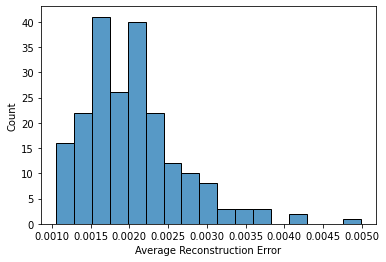

In [6]:
# Example of Histplot - for more plots see Plotting.ipynb
A = RE.reshape(20,-1,209).mean(axis=1)
df_opt_ae_4dim = pd.DataFrame(A[3], columns = ['Average Reconstruction Error'])
sns.histplot(data=df_opt_ae_4dim, x='Average Reconstruction Error')

In [7]:
np.save('df_opt_ae_RE', A)
np.save('opt_ae_MSE_TEST', MSE_TEST)
np.save('opt_ae_MSE_TRAIN', MSE_TRAIN)
np.save('df_opt_ae_OUT_TRAIN', output)
np.save('df_opt_ae_OUT_TEST', output_y)

In [37]:
%%time

# PCA Parameters

num = 25
dim = 20
test_size = 0.2
train_size = (1-test_size)*1042
ts = 1042 - train_size
pca_MSE_TRAIN = np.zeros((dim,num), dtype=float)
pca_MSE_TEST = np.zeros((dim,num), dtype=float)
pca_RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
repro_test = np.zeros((dim, num, math.ceil(ts), 384), dtype=float)

for comp in range(1,dim+1):
    print(f'\n\nCOMPONENT NUMBER {comp}')
    for i in range(num):
        print(f'\n\nTRIAL NUMBER {i}')
        X_train, X_test = train_test_split(scaleddf, test_size=test_size, shuffle=True)
        pca = PCA(n_components = comp)
        dim = pca.fit_transform(X_train)
        reprojected = pca.inverse_transform(dim)
        xvals2 = list(range(comp))

        print(pca.explained_variance_ratio_)

        dim_test = pca.transform(X_test)
        reprotest = pca.inverse_transform(dim_test)
        MSEtrain = mean_squared_error(X_train, reprojected)
        MSEtest = mean_squared_error(X_test, reprotest)
   
        print(MSEtrain)
        print(MSEtest)

        pca_MSE_TRAIN[comp-1][i] = MSEtrain
        pca_MSE_TEST[comp-1][i] = MSEtest
        repro_test[comp-1][i] = reprotest
        pca_RE[comp-1][i] = ((reprotest - X_test)**2).mean(axis=1)
    


print(f'MSE TRAIN: {pca_MSE_TRAIN}\n\nMSE TEST: {pca_MSE_TEST}\n\n')
print(f'MSE TRAIN MEAN: {pca_MSE_TRAIN.mean(axis=1)}\n\nMSE TEST MEAN: {pca_MSE_TEST.mean(axis=1)}\n\n')

B = pca_RE.reshape(20,-1,209).mean(axis=1)



COMPONENT NUMBER 1


TRIAL NUMBER 0
[0.61196769]
0.026580333460029592
0.027116555952844235


TRIAL NUMBER 1
[0.6066822]
0.026195159969762367
0.028447233188107896


TRIAL NUMBER 2
[0.60451149]
0.02606140293634701
0.02912574267657972


TRIAL NUMBER 3
[0.60821361]
0.026449621991022475
0.02748349333056369


TRIAL NUMBER 4
[0.59804237]
0.027565330678315642
0.023030881586866142


TRIAL NUMBER 5
[0.61124996]
0.026191932789784923
0.02849899501498762


TRIAL NUMBER 6
[0.60950332]
0.026650990868817916
0.026648971143920907


TRIAL NUMBER 7
[0.61582446]
0.02653882729330379
0.027156830474441035


TRIAL NUMBER 8
[0.59795655]
0.02713609903821231
0.024737346489944006


TRIAL NUMBER 9
[0.61211127]
0.026085402043348815
0.029019113775700222


TRIAL NUMBER 10
[0.61080736]
0.026626362368323466
0.026816954429875025


TRIAL NUMBER 11
[0.60477522]
0.026985934660593753
0.025296035274303103


TRIAL NUMBER 12
[0.60116441]
0.026722793378077248
0.02636761352720934


TRIAL NUMBER 13
[0.60725623]
0.026684457792240

0.0023175493193713097
0.0026681393205132777


TRIAL NUMBER 19
[0.60587537 0.16050749 0.10186737 0.09510204]
0.0024929781544102796
0.0020052353492123155


TRIAL NUMBER 20
[0.60861545 0.162303   0.10200618 0.09174565]
0.0023394225939260913
0.0025683329024164246


TRIAL NUMBER 21
[0.60230317 0.15788127 0.10921376 0.09540673]
0.002433585886456343
0.0022019860178478807


TRIAL NUMBER 22
[0.605116   0.15700948 0.10659231 0.09770663]
0.0022764278250173684
0.0028196119002135075


TRIAL NUMBER 23
[0.60472076 0.15930492 0.10329965 0.09892196]
0.0022413579855501144
0.002990894962778074


TRIAL NUMBER 24
[0.60770486 0.15685499 0.10520442 0.09567023]
0.0022920284688738783
0.0027759388575216877


COMPONENT NUMBER 5


TRIAL NUMBER 0
[0.60521076 0.15693141 0.10550171 0.10024062 0.013133  ]
0.0012856486451104697
0.002280010064839553


TRIAL NUMBER 1
[0.60885551 0.15812651 0.10497406 0.09419622 0.01303794]
0.0013817021145660746
0.0018698781121911237


TRIAL NUMBER 2
[0.60543964 0.1614975  0.10583009 0.0

0.0006331309384900782
0.0004996670868561247


TRIAL NUMBER 10
[0.61306618 0.15002702 0.1062838  0.09800071 0.01281063 0.00647785
 0.00545365]
0.0005371200282630836
0.0009068203946610065


TRIAL NUMBER 11
[0.60884404 0.15685532 0.10698842 0.0928139  0.01328841 0.00746167
 0.00551416]
0.0005578443442591243
0.000827592429906827


TRIAL NUMBER 12
[0.61230987 0.15534208 0.10807066 0.08903225 0.01330931 0.00753981
 0.00562159]
0.0005931389244546891
0.0006694256755260383


TRIAL NUMBER 13
[0.60886376 0.15931467 0.10184271 0.09422396 0.01399331 0.00724636
 0.00582128]
0.000587422830865459
0.0007149378418542284


TRIAL NUMBER 14
[0.6006577  0.15733268 0.10589173 0.10134898 0.01300034 0.00748935
 0.00579861]
0.0005781677311068595
0.0007250503273342562


TRIAL NUMBER 15
[0.61013331 0.1514586  0.10498884 0.09998499 0.01234366 0.00722927
 0.00542603]
0.0005667228291064466
0.0007749600043648365


TRIAL NUMBER 16
[0.59842766 0.16097926 0.1041546  0.10084768 0.01470031 0.00677874
 0.00562065]
0.000573

0.0002272648224412212
0.0003344760383866148


TRIAL NUMBER 15
[0.60670883 0.15252597 0.10504717 0.10028199 0.01301782 0.0075068
 0.00559677 0.00399828 0.00168274]
0.0002442622858177458
0.0002504217522273222


TRIAL NUMBER 16
[0.61208604 0.15868475 0.10170044 0.09150244 0.01407689 0.00719818
 0.00555268 0.00375993 0.00166762]
0.00025418855948485864
0.0002120857413581956


TRIAL NUMBER 17
[0.61134684 0.15465153 0.1052536  0.09455959 0.01321685 0.00720896
 0.0052265  0.00375191 0.00164016]
0.000214129263374737
0.0003925494564683255


TRIAL NUMBER 18
[0.60329042 0.15872934 0.10674208 0.09426303 0.0140518  0.00746614
 0.00599861 0.00389566 0.00178015]
0.0002565126767396372
0.00020390975202528588


TRIAL NUMBER 19
[0.6086856  0.15626499 0.1048876  0.09406983 0.01314552 0.00755119
 0.00597429 0.00397265 0.00175618]
0.00025139444975685567
0.00022470707638566926


TRIAL NUMBER 20
[0.60193197 0.15950319 0.10840363 0.0931447  0.01400088 0.00771648
 0.00571243 0.00412583 0.00167425]
0.000256257751

8.673661574285398e-05
8.117583120335695e-05


TRIAL NUMBER 13
[0.61262135 0.14911293 0.10599891 0.09795395 0.01285704 0.00684959
 0.0054681  0.00368827 0.00167472 0.00145547 0.00103411]
8.70939290304429e-05
8.179512787808955e-05


TRIAL NUMBER 14
[0.60406179 0.15587515 0.10671328 0.0993751  0.01351106 0.00689968
 0.00526807 0.00369043 0.001518   0.00103601 0.00088262]
7.995328592076406e-05
0.00011551102361652726


TRIAL NUMBER 15
[0.60124767 0.16443237 0.10499548 0.09168773 0.01440449 0.00729315
 0.00625545 0.00395811 0.00175249 0.00147072 0.00115126]
9.170130531652778e-05
6.368483676961503e-05


TRIAL NUMBER 16
[0.60380648 0.15723831 0.10769112 0.0956811  0.01374884 0.00721582
 0.00578887 0.00372962 0.00169896 0.00120157 0.00100811]
8.055902040688886e-05
0.00011240574938491689


TRIAL NUMBER 17
[0.6116083  0.14811798 0.10589187 0.09863419 0.01350752 0.00719878
 0.00602447 0.00366367 0.00171421 0.00133775 0.00105506]
8.535807351794282e-05
9.247898384802146e-05


TRIAL NUMBER 18
[0.6034

3.514783292272506e-05
4.085768189326257e-05


TRIAL NUMBER 1
[6.03364588e-01 1.57182395e-01 1.04571362e-01 9.86515889e-02
 1.38545108e-02 7.31689612e-03 5.76727756e-03 3.87056531e-03
 1.68243489e-03 1.43381495e-03 1.06968124e-03 5.13527199e-04
 2.11375513e-04]
3.4374071374273286e-05
4.3355883849318794e-05


TRIAL NUMBER 2
[6.05335206e-01 1.58952670e-01 1.04163756e-01 9.73858325e-02
 1.29738466e-02 7.32207233e-03 5.56091414e-03 3.59388626e-03
 1.54030733e-03 1.05431060e-03 9.21627116e-04 4.73685793e-04
 1.96915288e-04]
3.539272300185966e-05
4.054388920042723e-05


TRIAL NUMBER 3
[6.05410150e-01 1.58352230e-01 1.02793615e-01 9.81495038e-02
 1.39598879e-02 6.99910986e-03 5.62732660e-03 3.33935459e-03
 1.69938957e-03 1.45141593e-03 9.53852006e-04 5.47103556e-04
 2.03105416e-04]
3.463285809291349e-05
4.611602676884049e-05


TRIAL NUMBER 4
[6.05390426e-01 1.60907733e-01 1.03844940e-01 9.52604602e-02
 1.30728655e-02 6.82685246e-03 5.70938372e-03 3.75912411e-03
 1.66191102e-03 1.26792328e-03 9

[6.04297557e-01 1.54037611e-01 1.06129974e-01 9.98709871e-02
 1.31209313e-02 7.48472783e-03 5.79551642e-03 3.70479772e-03
 1.74405033e-03 1.48347707e-03 1.06545116e-03 5.60014727e-04
 2.03213956e-04 1.67214292e-04]
2.2882713435593526e-05
3.3630919399680894e-05


TRIAL NUMBER 9
[6.10155117e-01 1.55391368e-01 1.07164214e-01 9.13663443e-02
 1.42705810e-02 7.37994216e-03 5.19608404e-03 3.93092691e-03
 1.51833783e-03 1.35953722e-03 1.01336559e-03 5.17014383e-04
 2.06331993e-04 1.66207723e-04]
2.4752666360961713e-05
2.465910625167786e-05


TRIAL NUMBER 10
[6.01638459e-01 1.60195879e-01 1.05074562e-01 9.75579984e-02
 1.32185866e-02 7.50961662e-03 5.69507501e-03 4.00619025e-03
 1.60691782e-03 1.21772639e-03 9.81627930e-04 5.36646265e-04
 2.22230028e-04 1.57832093e-04]
2.5817994138521528e-05
2.0372283672625592e-05


TRIAL NUMBER 11
[6.19122366e-01 1.46846663e-01 1.05841829e-01 9.48333002e-02
 1.24882471e-02 6.96956852e-03 5.39865310e-03 3.83394776e-03
 1.55602752e-03 1.08069962e-03 8.59883579e-

1.3703670067500212e-05
3.021460036539196e-05


TRIAL NUMBER 13
[6.00082161e-01 1.62141556e-01 1.08954973e-01 9.32324865e-02
 1.35341814e-02 7.41417662e-03 5.62948195e-03 3.74128791e-03
 1.63890617e-03 1.31654341e-03 1.04045563e-03 5.13061946e-04
 2.19199525e-04 1.69601346e-04 1.19313110e-04]
1.6940195452735326e-05
1.5023578426554331e-05


TRIAL NUMBER 14
[6.09028724e-01 1.53989189e-01 1.04788184e-01 9.79081003e-02
 1.35132151e-02 6.31684594e-03 5.74443911e-03 3.32533315e-03
 1.68066165e-03 1.45210955e-03 1.00448422e-03 5.40981589e-04
 2.05125793e-04 1.48841068e-04 1.18959643e-04]
1.578632235736125e-05
2.0868889824646343e-05


TRIAL NUMBER 15
[6.13245392e-01 1.54593431e-01 1.03497754e-01 9.44307378e-02
 1.30440948e-02 6.94814409e-03 5.47877354e-03 3.51775207e-03
 1.55934385e-03 1.43261235e-03 9.77487011e-04 5.48810724e-04
 1.94484232e-04 1.70767120e-04 1.28679695e-04]
1.5574563533344155e-05
2.1026048275468646e-05


TRIAL NUMBER 16
[6.06267424e-01 1.53203862e-01 1.07690529e-01 9.64562932



TRIAL NUMBER 17
[6.04727216e-01 1.53677386e-01 1.05437359e-01 1.00986897e-01
 1.27038918e-02 7.36952788e-03 5.82558056e-03 3.63913432e-03
 1.71428867e-03 1.49194876e-03 1.08884779e-03 5.79519426e-04
 2.18768464e-04 1.69036590e-04 1.29836061e-04 8.60452964e-05]
1.039147253452412e-05
1.3116462305600936e-05


TRIAL NUMBER 18
[6.09556408e-01 1.57725546e-01 1.02497099e-01 9.71911025e-02
 1.38526023e-02 6.85383799e-03 5.02396443e-03 3.41110376e-03
 1.44230316e-03 1.02297813e-03 5.78051187e-04 3.17965821e-04
 1.75171148e-04 1.09395302e-04 8.92409373e-05 4.74915347e-05]
7.183691882670489e-06
0.00026973316199684554


TRIAL NUMBER 19
[6.03911339e-01 1.60523855e-01 1.05227230e-01 9.56913652e-02
 1.41159080e-02 6.83230745e-03 5.52393141e-03 3.26452934e-03
 1.62568879e-03 1.16129235e-03 8.78119586e-04 5.16382560e-04
 2.05373919e-04 1.73887049e-04 1.08066037e-04 8.50606345e-05]
1.0661607831895104e-05
1.1859655866239687e-05


TRIAL NUMBER 20
[6.12800870e-01 1.59038424e-01 1.02486755e-01 9.10031536e

[6.17009694e-01 1.51242307e-01 1.05432163e-01 9.22912365e-02
 1.30806714e-02 7.28375896e-03 5.33316129e-03 3.67663611e-03
 1.50611154e-03 1.06956357e-03 9.20772067e-04 4.74461684e-04
 2.11224863e-04 1.54670945e-04 1.02863242e-04 6.90264501e-05
 4.37881291e-05]
6.644649138882261e-06
1.2127947870485876e-05


TRIAL NUMBER 20
[6.08483653e-01 1.53686658e-01 1.05336725e-01 9.75251571e-02
 1.37085072e-02 7.30314154e-03 5.43211014e-03 3.88885070e-03
 1.51421793e-03 1.09898289e-03 8.69518758e-04 4.25522588e-04
 2.14273969e-04 1.60218614e-04 1.22714369e-04 7.84191260e-05
 5.31796770e-05]
6.6771932952003895e-06
1.1754862326102996e-05


TRIAL NUMBER 21
[6.00630063e-01 1.59330299e-01 1.05356053e-01 9.72265508e-02
 1.42137138e-02 7.69569075e-03 5.98335664e-03 3.89214335e-03
 1.73398274e-03 1.50000581e-03 1.10665146e-03 5.71871488e-04
 2.28823633e-04 1.58274348e-04 1.25652412e-04 8.43699220e-05
 5.39176284e-05]
7.281230570311454e-06
8.349388092899452e-06


TRIAL NUMBER 22
[6.04914672e-01 1.63775005e-

[6.02579103e-01 1.59636411e-01 1.06848294e-01 9.51468161e-02
 1.38708763e-02 7.82019782e-03 5.49835389e-03 3.79000835e-03
 1.57743996e-03 1.08700217e-03 9.30063417e-04 4.56690684e-04
 2.18640624e-04 1.61762738e-04 1.31858945e-04 8.77484962e-05
 4.81721207e-05 4.66677032e-05]
4.310400127706921e-06
4.927310691835596e-06


TRIAL NUMBER 20
[6.07959709e-01 1.59091916e-01 1.06080597e-01 9.18494070e-02
 1.32925550e-02 7.39828918e-03 5.51986704e-03 3.96736124e-03
 1.60359245e-03 1.15757737e-03 8.75963863e-04 4.88766528e-04
 2.07275098e-04 1.60796724e-04 1.11687559e-04 8.16812371e-05
 4.86545261e-05 4.03513456e-05]
4.318966624932934e-06
5.255263848966905e-06


TRIAL NUMBER 21
[5.95918104e-01 1.59302844e-01 1.10976512e-01 9.60217586e-02
 1.36685563e-02 8.07662258e-03 6.19523998e-03 4.12465369e-03
 1.78438132e-03 1.43208140e-03 1.18615761e-03 5.41534232e-04
 2.22911504e-04 1.81289911e-04 1.29025351e-04 7.78175910e-05
 4.92720657e-05 4.43567813e-05]
4.520282263868866e-06
4.081538388242965e-06


TR

2.212097763020474e-06


TRIAL NUMBER 19
[6.05417377e-01 1.58469750e-01 1.07808009e-01 9.32919122e-02
 1.29936694e-02 7.43348293e-03 5.79617567e-03 3.73043662e-03
 1.66613415e-03 1.23299703e-03 1.00396682e-03 5.23863921e-04
 1.64490546e-04 1.56611377e-04 1.08688065e-04 5.62547373e-05
 4.76164476e-05 4.14798628e-05 2.49827390e-05]
2.1582094730379643e-06
5.158035869655759e-06


TRIAL NUMBER 20
[6.09164099e-01 1.52478543e-01 1.05866465e-01 9.87005751e-02
 1.32557924e-02 6.69712491e-03 5.61082882e-03 3.69372123e-03
 1.40322034e-03 1.03339362e-03 8.59950915e-04 4.85279141e-04
 2.09033683e-04 1.72324927e-04 1.22202135e-04 9.29202157e-05
 4.91385388e-05 4.19850569e-05 2.49641699e-05]
2.601408267163991e-06
2.726990311582003e-06


TRIAL NUMBER 21
[6.07775167e-01 1.52812430e-01 1.08511656e-01 9.42480081e-02
 1.34693834e-02 7.79063604e-03 5.91152516e-03 4.04867062e-03
 1.65496574e-03 1.46256054e-03 1.00095033e-03 5.51179554e-04
 2.21915442e-04 1.76228273e-04 1.24987189e-04 7.77384044e-05
 5.031011



TRIAL NUMBER 17
[6.08124916e-01 1.59661884e-01 1.04067902e-01 9.20460882e-02
 1.39436244e-02 7.51309999e-03 5.49923064e-03 3.69127544e-03
 1.68374401e-03 1.45081037e-03 1.04690728e-03 5.40954964e-04
 2.01052200e-04 1.67032845e-04 1.17536691e-04 8.60443138e-05
 5.30888412e-05 4.33681973e-05 2.53980917e-05 1.29366281e-05]
1.5750983914747183e-06
2.5049202410224087e-06


TRIAL NUMBER 18
[6.06412875e-01 1.60269148e-01 1.04974032e-01 9.15470670e-02
 1.38854425e-02 7.34122948e-03 6.17531801e-03 3.85928012e-03
 1.82571508e-03 1.34522739e-03 1.07972984e-03 5.15443944e-04
 2.33642515e-04 1.72442424e-04 1.25673285e-04 7.82648842e-05
 5.11107666e-05 4.43871698e-05 2.64507033e-05 1.27054529e-05]
1.6596141352298802e-06
2.1026145775560943e-06


TRIAL NUMBER 19
[6.14656675e-01 1.53770015e-01 1.05429165e-01 9.24111187e-02
 1.34712262e-02 6.93651638e-03 5.10868990e-03 3.66034365e-03
 1.35653974e-03 1.08414124e-03 9.23554515e-04 4.77027397e-04
 1.96260570e-04 1.72584330e-04 1.16132628e-04 7.42852295e-0

In [39]:
np.save('df_opt_pca_RE', B)
np.save('opt_pca_MSE_TEST', pca_MSE_TEST)
np.save('opt_pca_MSE_TRAIN', pca_MSE_TRAIN)